# Dataset Preparation

### Importing of libraries

In [412]:
import pandas as pd
import os
import pickle
import re

from collections import Counter
from vocab import Vocab, Vectors
from wordebd import WORDEBD

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from model import DATASET_PATH

%matplotlib inline
plt.style.use("fivethirtyeight")

In [413]:
dataset_path = DATASET_PATH

### Importing of data

In [414]:
dataset_path = "dataset_drop_noise"

# Read the CSV file
TrainData = pd.read_csv('data/dataset_original/train_sent_emo_dya.csv', encoding='shift_jis')
TestData = pd.read_csv('data/dataset_original/test_sent_emo_dya.csv', encoding='utf-8')
DevData = pd.read_csv('data/dataset_original/dev_sent_emo_dya.csv', encoding='utf-8')

# Display the first three rows
print(TrainData.shape)
print(TestData.shape)
print(DevData.shape)


(12840, 12)
(3400, 12)
(1462, 12)


### Checking statistics

In [415]:
def showTotalEmotions(df):
    data = pd.DataFrame(columns=["Emotion", "Count"])
    data['Emotion'] = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
    count = []

    for emotion in data['Emotion']:
        count.append(df[df["Emotion"] == emotion].shape[0])
    
    data['Count'] = count

    return data

print("Train Data Emotion Count: \n", showTotalEmotions(TrainData), "\n")
print("Test Data Emotion Count: \n", showTotalEmotions(TestData), "\n")
print("Validation Data Emotion Count: \n", showTotalEmotions(DevData), "\n")


Train Data Emotion Count: 
     Emotion  Count
0     anger   1500
1   disgust    364
2      fear    338
3       joy   2312
4   neutral   5960
5   sadness    876
6  surprise   1490 

Test Data Emotion Count: 
     Emotion  Count
0     anger    516
1   disgust     99
2      fear     60
3       joy    495
4   neutral   1615
5   sadness    263
6  surprise    352 

Validation Data Emotion Count: 
     Emotion  Count
0     anger    208
1   disgust     31
2      fear     54
3       joy    214
4   neutral    600
5   sadness    145
6  surprise    210 



In [416]:
def count_unique_words(df):
    # Combine all utterances into a single string
    all_text = ' '.join(df['Utterance'].astype(str).tolist())
    
    # Remove non-alphanumeric characters and split into words
    words = re.findall(r'\b\w+\b', all_text)
    
    # Remove single-letter words
    words = [word for word in words if len(word) > 1]\
    
    # Count the unique words
    word_counts = Counter(words)
    
    # Convert to a dataframe
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])

     # Sort the dataframe by 'Count' in descending order
    word_counts_df = word_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    
    return word_counts_df

print(count_unique_words(TrainData).shape)
print(count_unique_words(TestData).shape)
print(count_unique_words(DevData).shape)

(5955, 2)
(2689, 2)
(1573, 2)


### Dropping of Features

Drop Old_Dialogue_ID, Old_Utterance_ID, Season, Episode, StartTime, and EndTime

In [417]:
# Define features to drop
# drop_features = list(TrainData.columns[6:]) 
# drop_features

In [418]:
# Drop features from X_train DataFrame
# TrainData = TrainData.drop(drop_features, axis=1)
# TestData = TestData.drop(drop_features, axis=1)
# DevData = DevData.drop(drop_features, axis=1)

In [419]:
key = True

checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/label_decoder.pkl")

if not (checkFile1 and checkFile2):
    labels = sorted(set(TrainData.Emotion))
    labelEncoder = {label: i for i, label in enumerate(labels)}
    labelDecoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(labelEncoder, open('data/dump/' + dataset_path + '/label_encoder.pkl', 'wb'))
    pickle.dump(labelDecoder, open('data/dump/' + dataset_path + '/label_decoder.pkl', 'wb'))
else:
    file1 = open('data/dump/' + dataset_path + '/label_encoder.pkl', 'rb')
    file2 = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
    labelEncoder = pickle.load(file1)
    labelDecoder = pickle.load(file2)
    file1.close()
    file2.close()

In [420]:
# labelEncoder

In [421]:
def encode_labels(encoder, l):
    return encoder[l]

In [422]:
# Apply label encoding to the "Emotion" column in y_train
TrainData["Emotion"] = TrainData["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
TestData["Emotion"] = TestData["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
DevData["Emotion"] = DevData["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))

In [423]:
# def find_value_ranges(lst):
#     value_ranges = []
#     start_index = 0

#     for i in range(1, len(lst)):
#         if lst[i] != lst[i - 1]:
#             value_ranges.append((start_index, i - 1))
#             start_index = i

#     # Add the last range
#     value_ranges.append((start_index, len(lst) - 1))

#     return value_ranges

### Copying orginal dataset

This section will copy the current dataframe to be ready for export and stored at dataset_original since dataset_original will NOT have any pre-processing of utterances. 

In [424]:
TrainData_Original =  TrainData.copy()
TestData_Original = TestData.copy()
DevData_Original = DevData.copy()

### Data Pre-Processing

In [425]:
# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Make a copy of X_train_utterances
train_utterances = TrainData['Utterance']
test_utterances = TestData['Utterance']
dev_utterances = DevData['Utterance']

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edayo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edayo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edayo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [426]:
def get_word_emotion_counts(df):
    # Define emotion mapping
    emotion_mapping = {
        'anger': 0,
        'disgust': 1,
        'fear': 2,
        'joy': 3,
        'neutral': 4,
        'sadness': 5,
        'surprise': 6
    }
    
    # Initialize an empty dictionary to store word counts for each emotion
    word_emotion_counts = {}

    # Iterate over each row in the dataframe
    for _, row in df.iterrows():
        utterance = row['Utterance'].split()  # Splitting utterance into words
        emotion = row['Emotion']

        # Get the emotion label
        emotion_label = list(emotion_mapping.keys())[emotion]
        
        # Iterate over each word in the set of words
        for word in utterance:
            if word not in word_emotion_counts:
                word_emotion_counts[word] = {key: 0 for key in emotion_mapping.keys()}
            word_emotion_counts[word][emotion_label] += 1

    # Convert the dictionary to a dataframe
    word_emotion_df = pd.DataFrame.from_dict(word_emotion_counts, orient='index')
    word_emotion_df = word_emotion_df.fillna(0).astype(int)  # Ensure all values are integers
    
    return word_emotion_df

train_word_emotion_counts = get_word_emotion_counts(TrainData)
test_word_emotion_counts = get_word_emotion_counts(TestData)
dev_word_emotion_counts = get_word_emotion_counts(DevData)

In [427]:
train_word_emotion_counts.head()

,anger,disgust,fear,joy,neutral,sadness,surprise
also,2,0,1,6,7,0,0
I,521,107,172,703,1599,474,255
was,73,19,18,121,225,66,58
the,318,100,40,374,1106,181,171
point,1,0,0,0,4,1,0


In [428]:
def plot_word_emotion_counts(df, top_n=10):
    # Define colors for each emotion
    emotion_colors = {
        'anger': 'red',
        'disgust': 'green',
        'fear': 'purple',
        'joy': 'yellow',
        'neutral': 'black',
        'sadness': 'darkblue',
        'surprise': 'orange'
    }
    
    # Plot the top N words for each emotion
    emotions = df.columns
    
    plt.style.use('default')  # Reset to default style for white background

    # Determine the number of rows needed based on the number of emotions and desired columns
    num_emotions = len(emotions)
    num_cols = 3
    num_rows = (num_emotions + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten axes for easy iteration

    for idx, emotion in enumerate(emotions):
        # Sort the dataframe by the count of the current emotion and get the top N words
        top_words = df[emotion].sort_values(ascending=False).head(top_n)
        
        # Create a bar plot
        axes[idx].bar(top_words.index, top_words.values, color=emotion_colors[emotion])
        axes[idx].set_title(f'Top {top_n} words for {emotion}')
        axes[idx].set_xlabel('Words')
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)
        
    # Hide any empty subplots
    for i in range(len(emotions), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

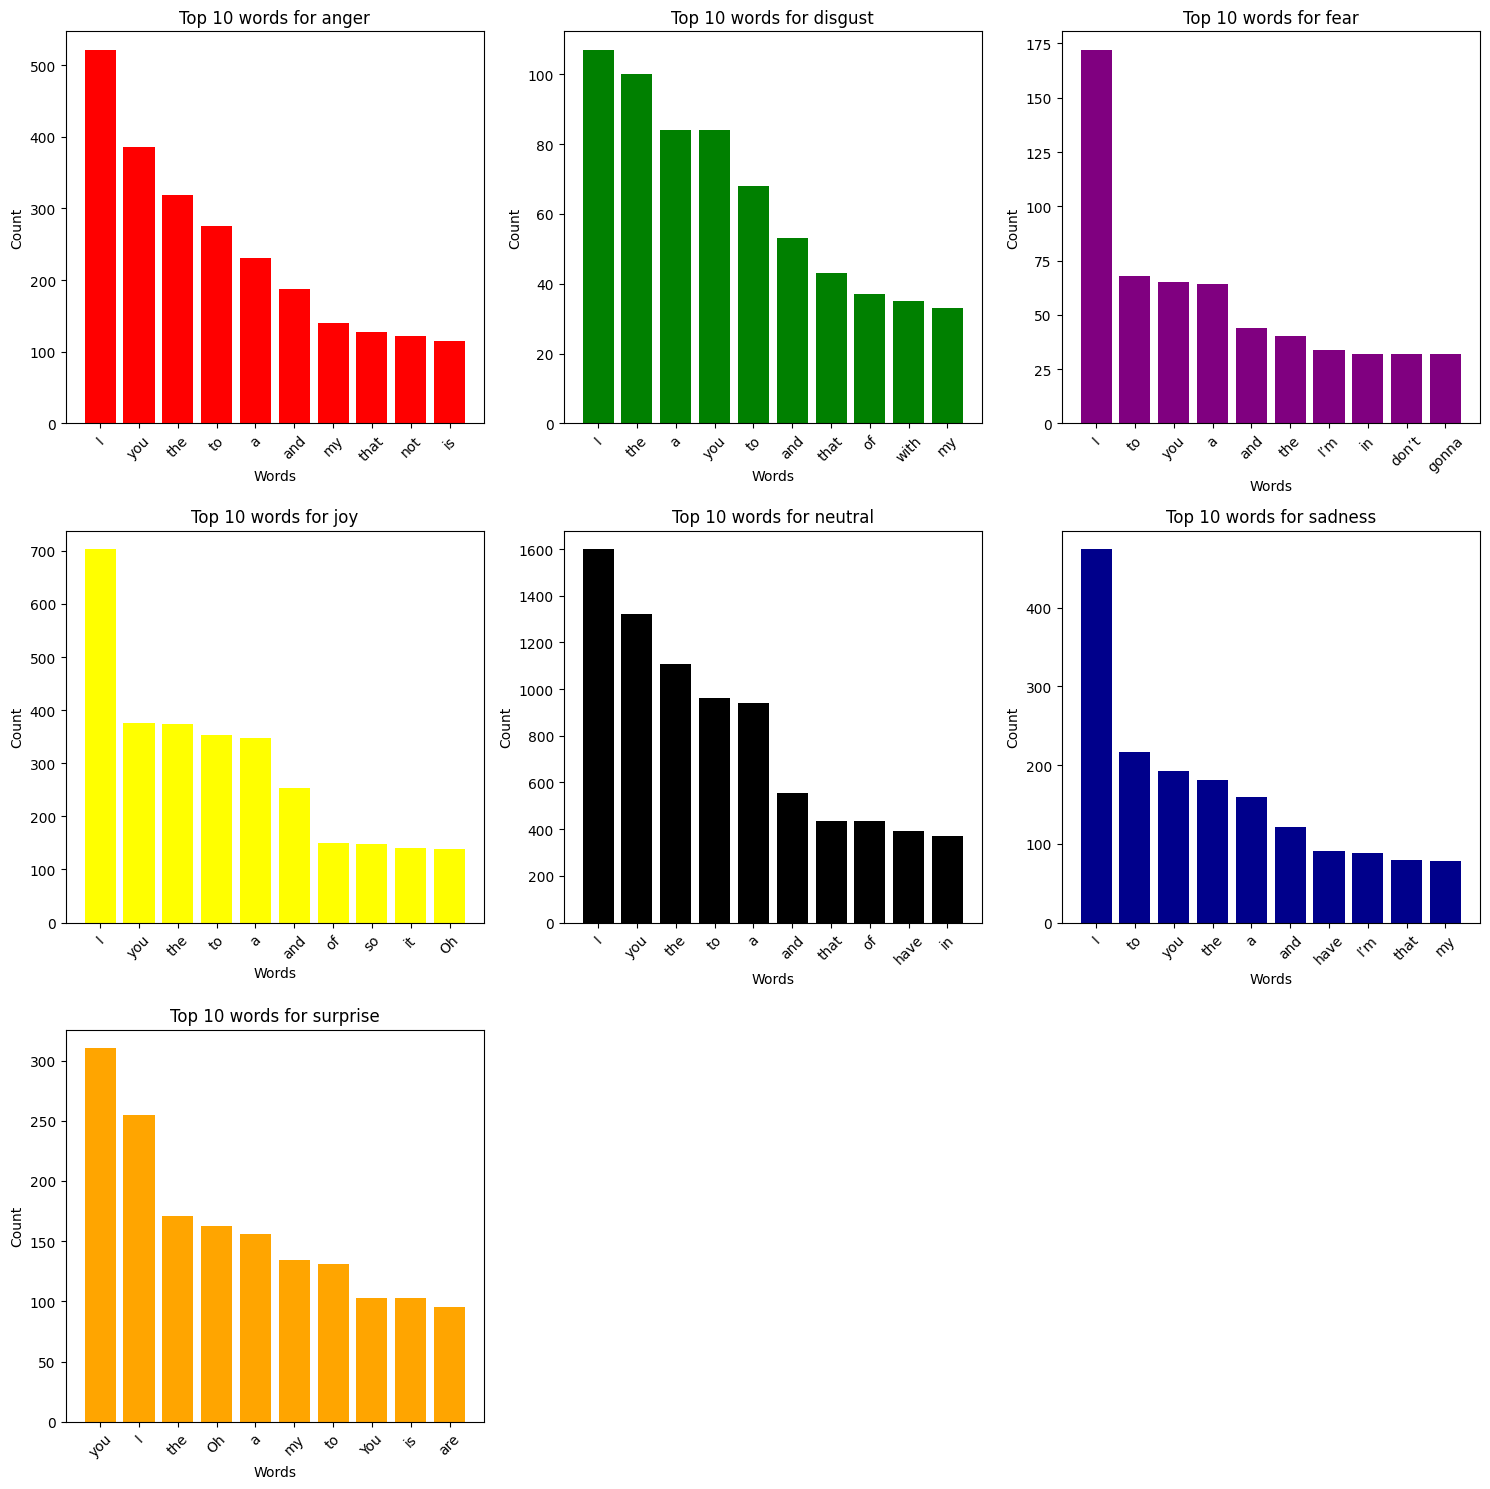

In [429]:
plot_word_emotion_counts(train_word_emotion_counts)

In [430]:
def clean_text(text):

    # Use regular expression to remove standalone punctuation
    text = re.sub(r'\s+[^\w\s]+\s+', ' ', text)  
    text = re.sub(r'^\s*[^\w\s]+\s*$', '', text)  
    text = re.sub(r'^\s*[^\w\s]+\s*', '', text)  
    text = re.sub(r'\s*[^\w\s]+\s*$', '', text) 

    # Tokenize
    words = word_tokenize(text)

    # Remove punctuation and non-alphabetic characters, and stop words
    words = [word for word in words if word not in stop_words]
    
    words = [word for word in words if word not in [',', '.', '\'', '!', '?']]
    words = [word for word in words if word not in [',', '.', '\'', '!', '?']]

    # Join words back into a single string
    cleaned_text = ' '.join(words)
    return cleaned_text


# Apply the clean_text function to each utterance
TrainData["Utterance"] = TrainData["Utterance"].apply(clean_text)
TestData["Utterance"] = TestData["Utterance"].apply(clean_text)
DevData["Utterance"] = DevData["Utterance"].apply(clean_text)

In [431]:
TrainData["Utterance"].sample(10)

2673                            How many times I told guys
5213     All right comes I ’ gon na I ’ gon na tell I ’...
6076     Uh say would umm… Would mind checking see umm ...
6559     Let 's get started Five six a-five six seven e...
5325                                                 Right
11147                                               Do sit
1976                           We switching next rest stop
98                                              Great Okay
7905                                           Maybe level
9915                                            Oh You got
Name: Utterance, dtype: object

In [432]:
TestData["Utterance"].head()

0                     Why ’ coffee mugs numbers bottom
1    Oh That ’ Monica keep track That way one missi...
2                                               Y'know
3                                                 Okay
4                                Ross n't say elevator
Name: Utterance, dtype: object

In [433]:
DevData["Utterance"].head()

0                  Oh God ’ lost He ’ totally lost
1                                             What
2    Or Or could go bank close accounts cut source
3                                     You ’ genius
4                                     You ’ genius
Name: Utterance, dtype: object

Check for empty strings

In [434]:
# Count the empty string values in X_train_utterances
empty_string_count_train = (TrainData["Utterance"] == '').sum()
empty_string_count_test = (TestData["Utterance"] == '').sum()
empty_string_count_dev = (DevData["Utterance"] == '').sum()

print(f"Empty in Train Utterances: {empty_string_count_train}")
print(f"Empty in Test Utterances: {empty_string_count_test}")
print(f"Empty in Dev Utterances: {empty_string_count_dev}")

Empty in Train Utterances: 1
Empty in Test Utterances: 0
Empty in Dev Utterances: 0


Update 'Utterance' column and remove all empty strings

In [435]:
# # Update X_train with the cleaned utterances
# TrainData['Utterance'] = train_utterances
# TestData['Utterance'] = test_utterances
# DevData['Utterance'] = dev_utterances

# Ensure no leading/trailing spaces in Utterance
TrainData['Utterance'] = TrainData['Utterance'].str.strip()
TestData['Utterance'] = TestData['Utterance'].str.strip()
DevData['Utterance'] = DevData['Utterance'].str.strip()

# Drop rows where Utterance is an empty string. Empty string value is ''.
TrainData = TrainData[TrainData['Utterance'] != '']
TestData = TestData[TestData['Utterance'] != '']
DevData = DevData[DevData['Utterance'] != '']

# Reset the index
TrainData.reset_index(drop=True, inplace=True)
TestData.reset_index(drop=True, inplace=True)
DevData.reset_index(drop=True, inplace=True)

print(f"Train data shape after removing empty utterances: {TrainData.shape}")
print(f"Test data shape after removing empty utterances: {TestData.shape}")
print(f"Dev data shape after removing empty utterances: {DevData.shape}")

# Print some examples to debug
print("Some examples from TrainData after removing empty utterances:")
print(TrainData['Utterance'].head())

Train data shape after removing empty utterances: (12839, 12)
Test data shape after removing empty utterances: (3400, 12)
Dev data shape after removing empty utterances: (1462, 12)
Some examples from TrainData after removing empty utterances:
0    also I point person company ’ transition KL-5 ...
1                                You must ’ hands full
2                                        That I That I
3                      So let ’ talk little bit duties
4                                  My duties All right
Name: Utterance, dtype: object


In [437]:
len(TrainData)

12839

In [436]:
rangesTrain = find_value_ranges(TrainData["Dialogue_ID"])
print(len(rangesTrain))

rangesTest = find_value_ranges(TestData["Dialogue_ID"])
print(len(rangesTest))

rangesDev = find_value_ranges(DevData["Dialogue_ID"])
print(len(rangesDev))

2160
577
270


<b>Take note of new shape of Train and Test Data after dropping the values

Remove rows with *n* or below number of words and create a new **Dropped Words Dataset**

In [393]:
n = 2 # This number removes rows with n or fewer words. (Retains rows with more than n words)

# Retain rows with more than n words
TrainData = TrainData[TrainData['Utterance'].apply(lambda x: len(x.split()) > n)]
TestData = TestData[TestData['Utterance'].apply(lambda x: len(x.split()) > n)]
DevData = DevData[DevData['Utterance'].apply(lambda x: len(x.split()) > n)]

# Reset the index again
TrainData.reset_index(drop=True, inplace=True)
TestData.reset_index(drop=True, inplace=True)
DevData.reset_index(drop=True, inplace=True)

print(f"After removing rows with {n} words or fewer:")
print(f"Train shape : {TrainData.shape}")
print(f"Test shape: {TestData.shape}")
print(f"Dev shape: {DevData.shape}")

# Print some examples to debug
print("Some examples from TrainData after removing short utterances:")
print(TrainData['Utterance'].head())

After removing rows with 2 words or fewer:
Train shape : (9394, 12)
Test shape: (2494, 12)
Dev shape: (1073, 12)
Some examples from TrainData after removing short utterances:
0    also I point person company ’ transition KL-5 ...
1                                You must ’ hands full
2                                        That I That I
3                      So let ’ talk little bit duties
4                                  My duties All right
Name: Utterance, dtype: object


In [395]:
print(TrainData['Utterance'][40:46])

40    Listen I ’ ah I ’ sorry I ’ crazy jealous ’ I ...
41                                   Ameri-can Y'know ’
42                                   Ameri-can Y'know ’
43                     Good job Joe Well done Top notch
44                           You liked You really liked
45                                   Which part exactly
Name: Utterance, dtype: object

In [397]:
print(TrainData['Speaker'][40:46])

40        Ross
41      Phoebe
42      Phoebe
43    Chandler
44        Joey
45        Joey
Name: Speaker, dtype: object


In [398]:
print(TrainData['Emotion'][40:46])

40    5
41    4
42    4
43    3
44    6
45    4
Name: Emotion, dtype: int64


Get random sample from train and test data

In [349]:
# Randomly select 10 rows
random_sample = TrainData.sample(n=10)[["Utterance", "Emotion"]]

random_sample

,Utterance,Emotion
3582,Oh yeah With,6
6178,I think lover ’ spat start little early month,0
5487,I wanted thank last night great party,3
8045,Janice ’ birthday coming I want get something ...,4
1885,Look umm people want tell story,0
5445,You got ta take care,4
4248,Hey Any good mail,4
9312,You took watch,6
88,Fine You ’ ll-you ’ watch video get back,4
7393,I guess n't,4


In [350]:
# Randomly select 10 rows
random_sample = TestData.sample(n=10)[["Utterance", "Emotion"]]

random_sample

,Utterance,Emotion
1010,Oh Oh That 's hard,6
166,Oh I believe ’ using divorce sell mattresses,0
2290,What We 're going hospital,6
88,I mean enough silliness,0
2116,Oh anyway I wanted say wonderful I think,3
900,You said bald,0
960,Alright well good I love,3
1517,Look I ’ need steal stupid ring right,0
2409,I 'm sorry n't better news test last week I wa...,4
2089,I thought gon na closed casket,4


In [351]:
# Randomly select 10 rows
random_sample = DevData.sample(n=10)[["Utterance", "Emotion"]]

random_sample

,Utterance,Emotion
739,I ’ pregnant Ross Ross Okay whenever ’ ready A...,0
185,talked night realized reason angry still feeli...,5
807,Anyway ’ robot guy controls,4
747,You know course like ca n't possibly think any...,0
952,Joke Joke Blah Blah,0
19,I-I ’ sorry moment I touch I wan na throw old ...,0
136,Chandler 's girl,6
468,Oh I thought guys got married uh January,6
673,Of course ’ help Yeah We ’,3
1026,Ross Get shot ( He 's carrying issue,6


In [352]:
# # Custom color function using the "Spectral" colormap
# def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#     cmap = cm.get_cmap("Spectral")
#     colors = cmap(np.linspace(0, 1, 10))
#     return tuple(int(c * 255) for c in colors[np.random.randint(0, 10)])

# # Function to get the top 10 words from a word cloud
# def get_top_words(wordcloud):
#     word_freq = wordcloud.words_
#     top_words = [word for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]]
#     return top_words

# try:
#     # Corrected WordCloud generation for all datasets with custom color function
#     WC_Train = WordCloud(
#         max_words=2000, min_font_size=10, height=800, width=1600, background_color="white", color_func=color_func
#     ).generate(" ".join(TrainData.Utterance))

#     WC_Test = WordCloud(
#         max_words=2000, min_font_size=10, height=800, width=1600, background_color="white", color_func=color_func
#     ).generate(" ".join(TestData.Utterance))

#     WC_Dev = WordCloud(
#         max_words=2000, min_font_size=10, height=800, width=1600, background_color="white", color_func=color_func
#     ).generate(" ".join(DevData.Utterance))

#     # Get top 10 words for each dataset
#     top_words_train = get_top_words(WC_Train)
#     top_words_test = get_top_words(WC_Test)
#     top_words_dev = get_top_words(WC_Dev)

#     # Print the top words
#     print("Top words in TrainData:", top_words_train)
#     print("Top words in TestData:", top_words_test)
#     print("Top words in DevData:", top_words_dev)

#     # PLOT
#     fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))  # Adjust the layout and size as needed

#     wordclouds = [WC_Train, WC_Test, WC_Dev]
#     titles = ['TrainData', 'TestData', 'DevData']

#     # Plot each WordCloud
#     for idx, wc in enumerate(wordclouds):
#         axes[idx].imshow(wc, interpolation='bilinear')
#         axes[idx].set_title(titles[idx], fontsize=16)
#         axes[idx].axis('off')

#     plt.tight_layout()
#     plt.show()

# except Exception as e:
#     print(f"An error occurred: {e}")

### Division of X and y data

In [400]:
# Create DataFrame for target labels
y_train = pd.DataFrame()
y_test = pd.DataFrame()
y_dev = pd.DataFrame()

X_train = TrainData
X_test = TestData
X_dev = DevData
    
y_train["Emotion"] = TrainData["Emotion"].copy()
y_test["Emotion"] = TestData["Emotion"].copy()
y_dev["Emotion"] = DevData["Emotion"].copy()

y_train["Dialogue_ID"] = TrainData["Dialogue_ID"].copy()
y_test["Dialogue_ID"] = TestData["Dialogue_ID"].copy()
y_dev["Dialogue_ID"] = DevData["Dialogue_ID"].copy()

In [401]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print('--')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')
print('--')
print(f'Shape of X_dev: {X_dev.shape}')
print(f'Shape of y_dev: {y_dev.shape}')

Shape of X_train: (9394, 12)
Shape of y_train: (9394, 2)
--
Shape of X_test: (2494, 12)
Shape of y_test: (2494, 2)
--
Shape of X_dev: (1073, 12)
Shape of y_dev: (1073, 2)


### Output data to new csv

##### Label Encoding Data

In [403]:
# Check if the file already exists
# checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/labels_train.pkl")
# checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/labels_test.pkl")

pickle.dump(X_train["Emotion"], open('data/dump/' + dataset_path + '/labels_train.pkl', 'wb'))
pickle.dump(X_test["Emotion"], open('data/dump/' + dataset_path + '/labels_test.pkl', 'wb'))

##### Drop Noise Training and Testing Data

In [406]:
X_train[40:45]

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Old_Dialogue_ID,Old_Utterance_ID,Season,Episode,StartTime,EndTime
40,Listen I ’ ah I ’ sorry I ’ crazy jealous ’ I ...,Ross,5,negative,5,11,4,11,3,11,"00:20:44,284","00:20:53,584"
41,Ameri-can Y'know ’,Phoebe,4,neutral,6,2,5,2,3,15,"00:22:20,589","00:22:23,507"
42,Ameri-can Y'know ’,Phoebe,4,neutral,7,0,5,2,3,15,"00:22:20,589","00:22:23,507"
43,Good job Joe Well done Top notch,Chandler,3,positive,8,0,6,0,8,22,"00:12:24,315","00:12:27,526"
44,You liked You really liked,Joey,6,positive,8,1,6,1,8,22,"0:12:28,194","0:12:29,796"


In [404]:
# def exportDataToCSV(df, name):
#     path = "data/" + dataset_path + "/" + name + ".csv"
#     df.to_csv(path)


In [411]:
X_train.to_csv("data/" + dataset_path + "/train_sent_emo_dya.csv", index=False, encoding='shift_jis')
y_train.to_csv("y_train.csv", index=False)

# Export X_test and y_test
X_test.to_csv("data/" + dataset_path + "/test_sent_emo_dya.csv", index=False, encoding='utf-8')
y_test.to_csv("y_test.csv", index=False)

# Export X_dev and y_dev
X_dev.to_csv("data/" + dataset_path + "/dev_sent_emo_dya.csv", index=False, encoding='utf-8')
y_dev.to_csv("y_dev.csv", index=False)

##### Original Training and Testing Data

In [321]:
# exportDataToCSV(TrainData_Original, "X_train")
# exportDataToCSV(TrainData_Original['Emotion'], "y_train")

# exportDataToCSV(TestData_Original, "X_test")
# exportDataToCSV(TestData_Original['Emotion'], "y_test")

# exportDataToCSV(DevData_Original, "X_dev")
# exportDataToCSV(DevData_Original['Emotion'], "y_dev")